# Objectives
YWBAT
* build an OLS model that meets the assumptions
* use feature forward selection to find the best features
    * using VIF
    * using AIC
    * using BIC
* assess an OLS
* cross validate a model in sklearn

# Outline
* load in data
* load in libraries 
* find best features to start working with 
* encode/dummify categorical features
* build a model that meets the assumptions of an OLS
* cross validate the model with sklearn
* interpret the model 


# Modeling Flow for OLS
* build models in statsmodels until it meets all assumptions
    * build models on all the data 
* build the validated model in sklearn and cross validation test 
* final model 
    * or iterate on it to make it better

In [81]:
import warnings
from importlib import reload

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np 

import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as sms
import flatiron.statsFunctions as sf

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns

reload(sf)

<module 'flatiron.statsFunctions' from 'C:\\Users\\korsc\\Documents\\Flatiron\\phase_2\\PROJECT_2\\git_repo\\dsc-phase-2-project-online\\flatiron\\statsFunctions.py'>

In [46]:
df = pd.read_csv("./data/OLSChallenge.csv", encoding="ISO-8859-1")
df.head()

avgAnnCount  avgDeathsPerYear  TARGET_deathRate  incidenceRate  medIncome  \
0       1397.0               469             164.9          489.8      61898   
1        173.0                70             161.3          411.6      48127   
2        102.0                50             174.7          349.7      49348   
3        427.0               202             194.8          430.4      44243   
4         57.0                26             144.4          350.1      49955   

   popEst2015  povertyPercent  studyPerCap           binnedInc  MedianAge  \
0      260131            11.2   499.748204   (61494.5, 125635]       39.3   
1       43269            18.6    23.111234  (48021.6, 51046.4]       33.0   
2       21026            14.6    47.560164  (48021.6, 51046.4]       45.0   
3       75882            17.1   342.637253    (42724.4, 45201]       42.8   
4       10321            12.5     0.000000  (48021.6, 51046.4]       48.3   

   ...  PctPrivateCoverageAlone  PctEmpPrivCoverage PctPublicCoverage  \
0  ...                      NaN                41.6              32.9   
1  ...                     53.8                43.6              31.1   
2  ...                     43.5                34.9              42.1   
3  ...                     40.3                35.0              45.3   
4  ...                     43.9                35.1              44.0   

   PctPublicCoverageAlone   PctWhite  PctBlack  PctAsian  PctOtherRace  \
0                    14.0  81.780529  2.594728  4.821857      1.843479   
1                    15.3  89.228509  0.969102  2.246233      3.741352   
2                    21.1  90.922190  0.739673  0.465898      2.747358   
3                    25.0  91.744686  0.782626  1.161359      1.362643   
4                    22.7  94.104024  0.270192  0.665830      0.492135   

   PctMarriedHouseholds  BirthRate  
0             52.856076   6.118831  
1             45.372500   4.333096  
2             54.444868   3.729488  
3             51.021514   4.603841  
4             54.027460   6.796657  

[5 rows x 34 columns]

In [47]:
try:
    df = df.drop(columns=["PctSomeCol18_24"])
except:
    pass 
target = "avgDeathsPerYear"
df.isna().sum()

avgAnnCount                  0
avgDeathsPerYear             0
TARGET_deathRate             0
incidenceRate                0
medIncome                    0
popEst2015                   0
povertyPercent               0
studyPerCap                  0
binnedInc                    0
MedianAge                    0
MedianAgeMale                0
MedianAgeFemale              0
Geography                    0
AvgHouseholdSize             0
PercentMarried               0
PctNoHS18_24                 0
PctHS18_24                   0
PctBachDeg18_24              0
PctHS25_Over                 0
PctBachDeg25_Over            0
PctEmployed16_Over         152
PctUnemployed16_Over         0
PctPrivateCoverage           0
PctPrivateCoverageAlone    609
PctEmpPrivCoverage           0
PctPublicCoverage            0
PctPublicCoverageAlone       0
PctWhite                     0
PctBlack                     0
PctAsian                     0
PctOtherRace                 0
PctMarriedHouseholds         0
BirthRat

In [48]:
def corr_function(x, y):
    try:
        return x.corr(y)
    except:
        return None

In [49]:
# lets find some features based on their correlation scores

columns_correlations = []
columns_non_numeric = []

for column in df.drop(columns=[target]).columns:
    try:
        corr = np.abs(df[column].corr(df[target]))
        t = (column, corr)
        columns_correlations.append(t)
    except:
        columns_non_numeric.append(column)

# let's get all columns with correlation above 0.20

correlated_features_above_2 = [t[0] for t in columns_correlations if t[1] >= 0.20]
correlated_features_above_2

whole_space = correlated_features_above_2
whole_space.append(target)

correlated_df = df[whole_space]

correlated_df.head()

# plot a scatter matrix

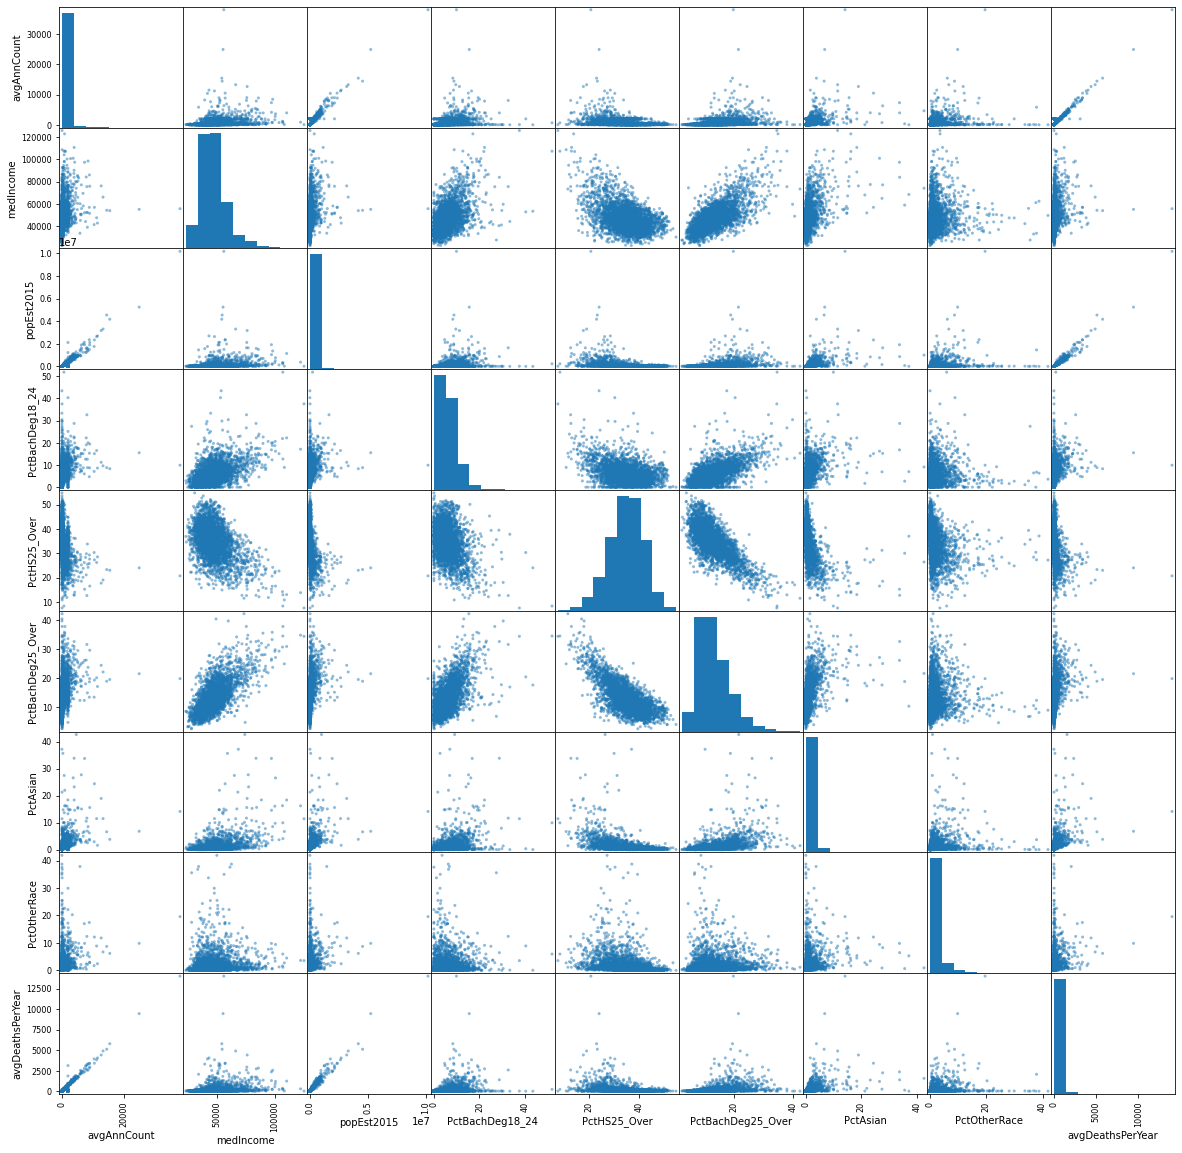

In [55]:
pd.plotting.scatter_matrix(correlated_df, figsize=(20, 20))
plt.show()

In [56]:
correlated_df.head()

avgAnnCount  medIncome  popEst2015  PctBachDeg18_24  PctHS25_Over  \
0       1397.0      61898      260131              6.9          23.2   
1        173.0      48127       43269              7.5          26.0   
2        102.0      49348       21026              9.5          29.0   
3        427.0      44243       75882              2.5          31.6   
4         57.0      49955       10321              2.0          33.4   

   PctBachDeg25_Over  PctAsian  PctOtherRace  avgDeathsPerYear  
0               19.6  4.821857      1.843479               469  
1               22.7  2.246233      3.741352                70  
2               16.0  0.465898      2.747358                50  
3                9.3  1.161359      1.362643               202  
4               15.0  0.665830      0.492135                26

In [57]:
# predicting something different
correlated_df['percentPopCount'] = correlated_df['avgAnnCount']/correlated_df['popEst2015']
correlated_df.head()

avgAnnCount  medIncome  popEst2015  PctBachDeg18_24  PctHS25_Over  \
0       1397.0      61898      260131              6.9          23.2   
1        173.0      48127       43269              7.5          26.0   
2        102.0      49348       21026              9.5          29.0   
3        427.0      44243       75882              2.5          31.6   
4         57.0      49955       10321              2.0          33.4   

   PctBachDeg25_Over  PctAsian  PctOtherRace  avgDeathsPerYear  \
0               19.6  4.821857      1.843479               469   
1               22.7  2.246233      3.741352                70   
2               16.0  0.465898      2.747358                50   
3                9.3  1.161359      1.362643               202   
4               15.0  0.665830      0.492135                26   

   percentPopCount  
0         0.005370  
1         0.003998  
2         0.004851  
3         0.005627  
4         0.005523

In [58]:
correlated_df['avgDeathsPerYearPerCapita'] = correlated_df['avgDeathsPerYear'] / correlated_df['popEst2015']
correlated_df.head()

avgAnnCount  medIncome  popEst2015  PctBachDeg18_24  PctHS25_Over  \
0       1397.0      61898      260131              6.9          23.2   
1        173.0      48127       43269              7.5          26.0   
2        102.0      49348       21026              9.5          29.0   
3        427.0      44243       75882              2.5          31.6   
4         57.0      49955       10321              2.0          33.4   

   PctBachDeg25_Over  PctAsian  PctOtherRace  avgDeathsPerYear  \
0               19.6  4.821857      1.843479               469   
1               22.7  2.246233      3.741352                70   
2               16.0  0.465898      2.747358                50   
3                9.3  1.161359      1.362643               202   
4               15.0  0.665830      0.492135                26   

   percentPopCount  avgDeathsPerYearPerCapita  
0         0.005370                   0.001803  
1         0.003998                   0.001618  
2         0.004851                   0.002378  
3         0.005627                   0.002662  
4         0.005523                   0.002519

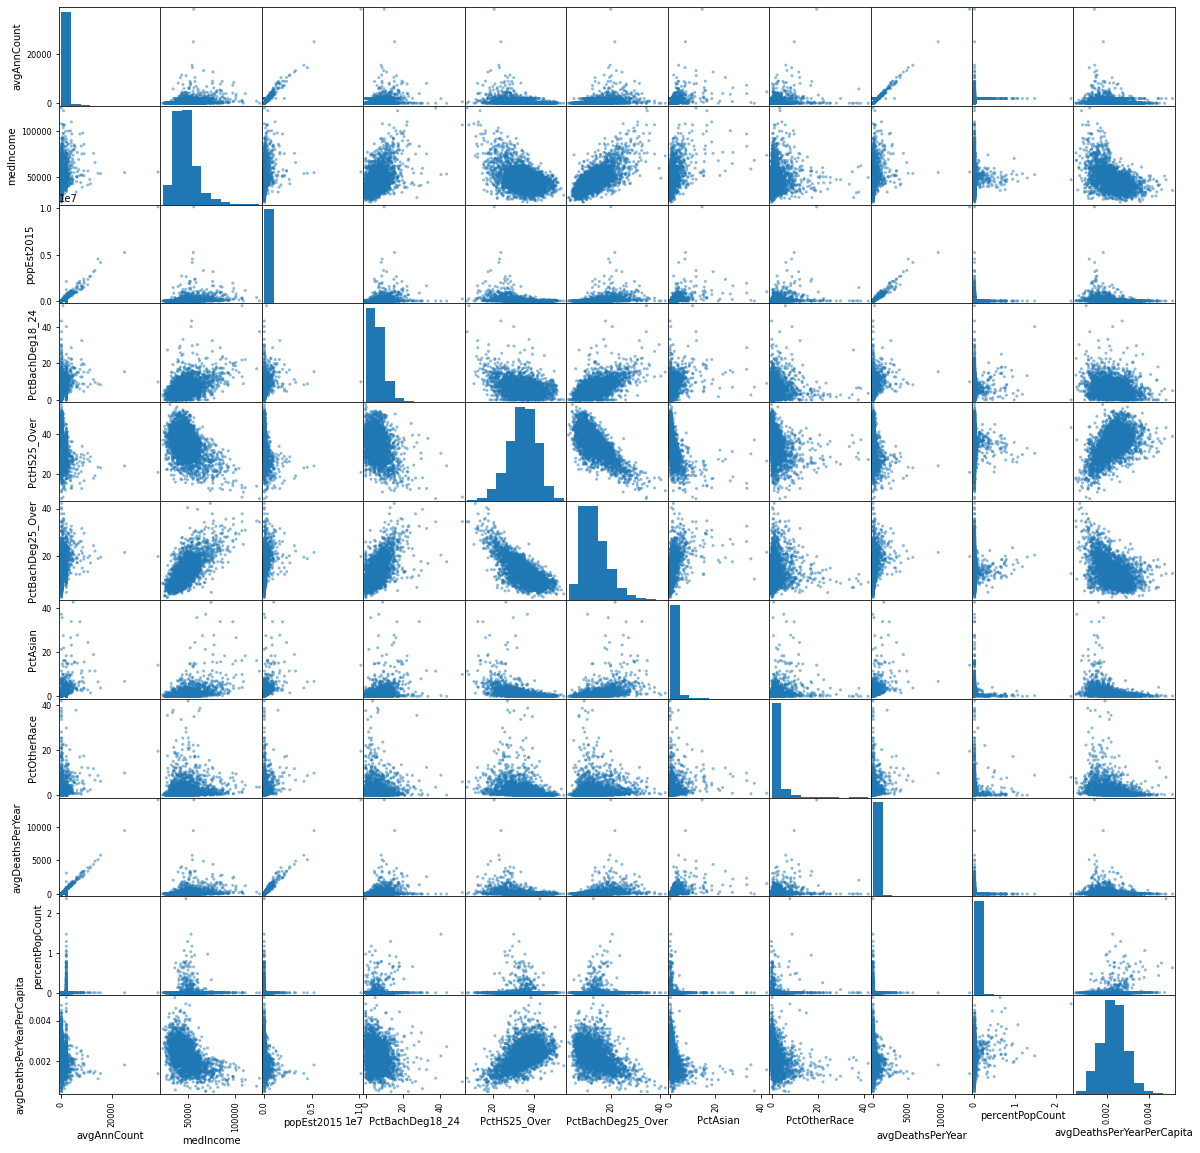

In [59]:
pd.plotting.scatter_matrix(correlated_df, figsize=(20, 20))
plt.show()

In [60]:
targets = ['avgDeathsPerYear', 'avgDeathsPerYearPerCapita']
target_o = 'avgDeathsPerYear'
target_per_capita = 'avgDeathsPerYearPerCapita'

In [61]:
ols = sf.check_model(correlated_df, features_to_use=correlated_features_above_2, target_col=target_per_capita)
ols 

avgAnnCount surpassed threshold with vif=10.55008514430632
medIncome surpassed threshold with vif=34.87396384146456
popEst2015 surpassed threshold with vif=26.51800630679161
PctBachDeg18_24 surpassed threshold with vif=4.619402452052047
PctHS25_Over surpassed threshold with vif=9.75714580065032
PctBachDeg25_Over surpassed threshold with vif=19.20990090598482
avgDeathsPerYear surpassed threshold with vif=32.0689057834666
Model contains multicollinear features
Residuals failed test/tests


In [62]:
correlated_features_above_2

['avgAnnCount',
 'medIncome',
 'popEst2015',
 'PctBachDeg18_24',
 'PctHS25_Over',
 'PctBachDeg25_Over',
 'PctAsian',
 'PctOtherRace',
 'avgDeathsPerYear']

In [63]:
correlated_features_low_vif = ['avgAnnCount', 'medIncome', 'PctBachDeg18_24', 
                               'PctHS25_Over', 'PctAsian', 'PctOtherRace']

In [64]:
ols = sf.check_model(df=correlated_df, features_to_use=correlated_features_low_vif, 
                     target_col=target_per_capita, show_summary=True)

medIncome surpassed threshold with vif=14.871168450250883
PctBachDeg18_24 surpassed threshold with vif=4.046214750187464
PctHS25_Over surpassed threshold with vif=8.721599994383705
Model contains multicollinear features
                                    OLS Regression Results                                    
Dep. Variable:     avgDeathsPerYearPerCapita   R-squared (uncentered):                   0.950
Model:                                   OLS   Adj. R-squared (uncentered):              0.949
Method:                        Least Squares   F-statistic:                              9548.
Date:                       Thu, 29 Oct 2020   Prob (F-statistic):                        0.00
Time:                               07:42:04   Log-Likelihood:                          18651.
No. Observations:                       3047   AIC:                                 -3.729e+04
Df Residuals:                           3041   BIC:                                 -3.725e+04
Df Model:           

<Figure size 1440x1440 with 0 Axes>

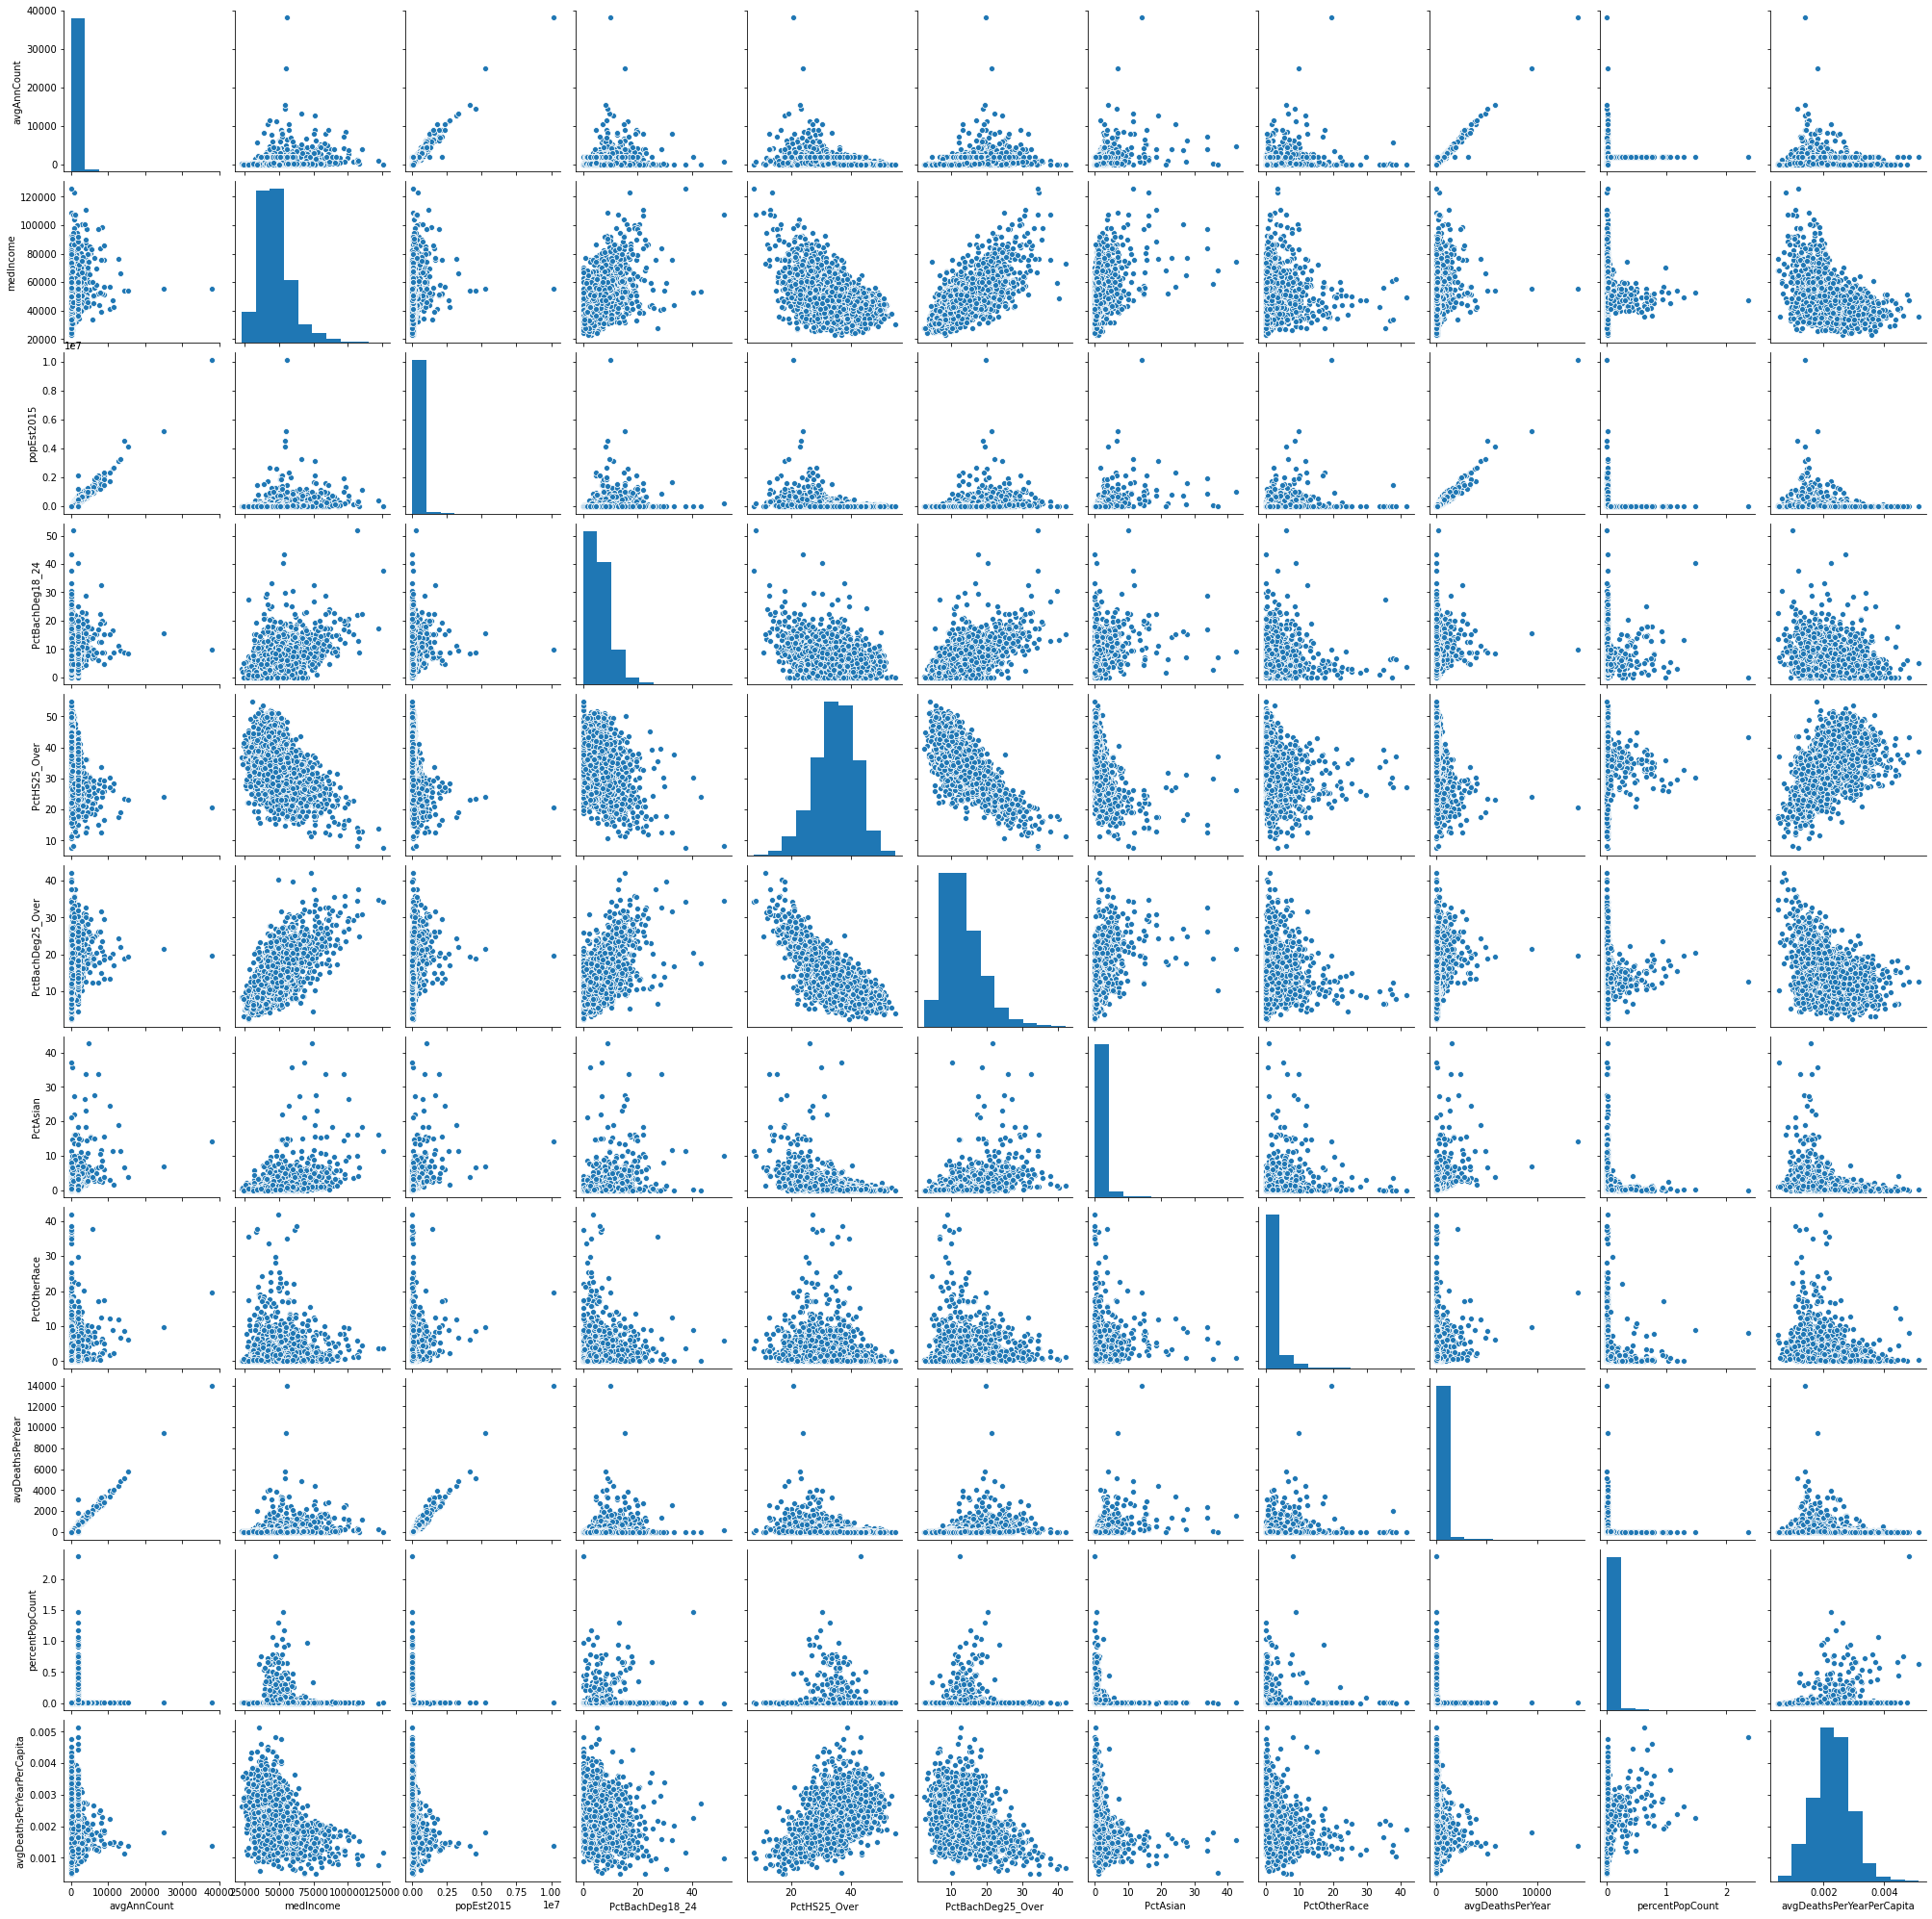

In [65]:
plt.figure(figsize=(20, 20))
sns.pairplot(data=correlated_df)
plt.show()

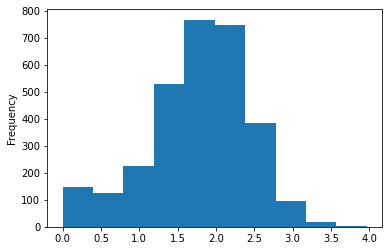

In [66]:
correlated_df['log_PctBachDeg18_24'] = np.log(correlated_df['PctBachDeg18_24'] + 1)
correlated_df['log_PctBachDeg18_24'].plot(kind='hist')
plt.show()

In [67]:
df.columns

Index(['avgAnnCount', 'avgDeathsPerYear', 'TARGET_deathRate', 'incidenceRate',
       'medIncome', 'popEst2015', 'povertyPercent', 'studyPerCap', 'binnedInc',
       'MedianAge', 'MedianAgeMale', 'MedianAgeFemale', 'Geography',
       'AvgHouseholdSize', 'PercentMarried', 'PctNoHS18_24', 'PctHS18_24',
       'PctBachDeg18_24', 'PctHS25_Over', 'PctBachDeg25_Over',
       'PctEmployed16_Over', 'PctUnemployed16_Over', 'PctPrivateCoverage',
       'PctPrivateCoverageAlone', 'PctEmpPrivCoverage', 'PctPublicCoverage',
       'PctPublicCoverageAlone', 'PctWhite', 'PctBlack', 'PctAsian',
       'PctOtherRace', 'PctMarriedHouseholds', 'BirthRate'],
      dtype='object')

In [68]:
ed_cols = [col for col in df.columns if 'HS' in col or 'Bach' in col]
ed_cols

['PctNoHS18_24',
 'PctHS18_24',
 'PctBachDeg18_24',
 'PctHS25_Over',
 'PctBachDeg25_Over']

In [69]:
education_df = df[ed_cols]

education_df['avgDeathsPerYearPerCapita'] = correlated_df['avgDeathsPerYearPerCapita']

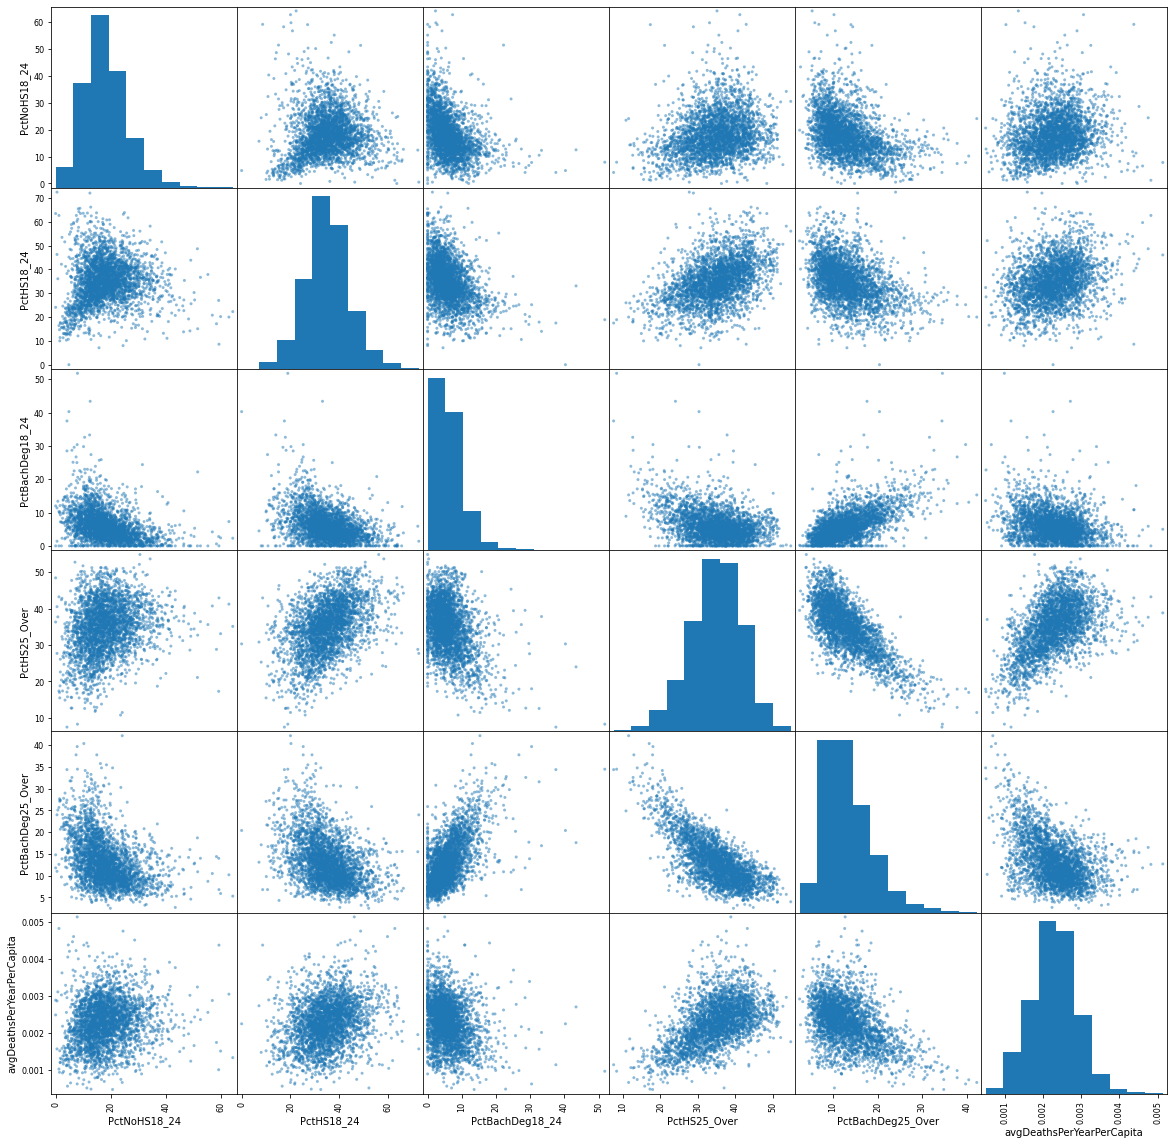

In [70]:
pd.plotting.scatter_matrix(education_df, figsize=(20, 20))
plt.show()

In [71]:
correlated_df['PctHS'] = education_df['PctHS25_Over'] + education_df['PctHS18_24']
correlated_df.head()

avgAnnCount  medIncome  popEst2015  PctBachDeg18_24  PctHS25_Over  \
0       1397.0      61898      260131              6.9          23.2   
1        173.0      48127       43269              7.5          26.0   
2        102.0      49348       21026              9.5          29.0   
3        427.0      44243       75882              2.5          31.6   
4         57.0      49955       10321              2.0          33.4   

   PctBachDeg25_Over  PctAsian  PctOtherRace  avgDeathsPerYear  \
0               19.6  4.821857      1.843479               469   
1               22.7  2.246233      3.741352                70   
2               16.0  0.465898      2.747358                50   
3                9.3  1.161359      1.362643               202   
4               15.0  0.665830      0.492135                26   

   percentPopCount  avgDeathsPerYearPerCapita  log_PctBachDeg18_24  PctHS  
0         0.005370                   0.001803             2.066863   62.7  
1         0.003998                   0.001618             2.140066   48.4  
2         0.004851                   0.002378             2.351375   65.6  
3         0.005627                   0.002662             1.252763   72.8  
4         0.005523                   0.002519             1.098612   76.4

In [72]:
correlated_df['PctBachDeg'] = education_df['PctBachDeg25_Over'] + education_df['PctBachDeg18_24']
correlated_df.head()

avgAnnCount  medIncome  popEst2015  PctBachDeg18_24  PctHS25_Over  \
0       1397.0      61898      260131              6.9          23.2   
1        173.0      48127       43269              7.5          26.0   
2        102.0      49348       21026              9.5          29.0   
3        427.0      44243       75882              2.5          31.6   
4         57.0      49955       10321              2.0          33.4   

   PctBachDeg25_Over  PctAsian  PctOtherRace  avgDeathsPerYear  \
0               19.6  4.821857      1.843479               469   
1               22.7  2.246233      3.741352                70   
2               16.0  0.465898      2.747358                50   
3                9.3  1.161359      1.362643               202   
4               15.0  0.665830      0.492135                26   

   percentPopCount  avgDeathsPerYearPerCapita  log_PctBachDeg18_24  PctHS  \
0         0.005370                   0.001803             2.066863   62.7   
1         0.003998                   0.001618             2.140066   48.4   
2         0.004851                   0.002378             2.351375   65.6   
3         0.005627                   0.002662             1.252763   72.8   
4         0.005523                   0.002519             1.098612   76.4   

   PctBachDeg  
0        26.5  
1        30.2  
2        25.5  
3        11.8  
4        17.0

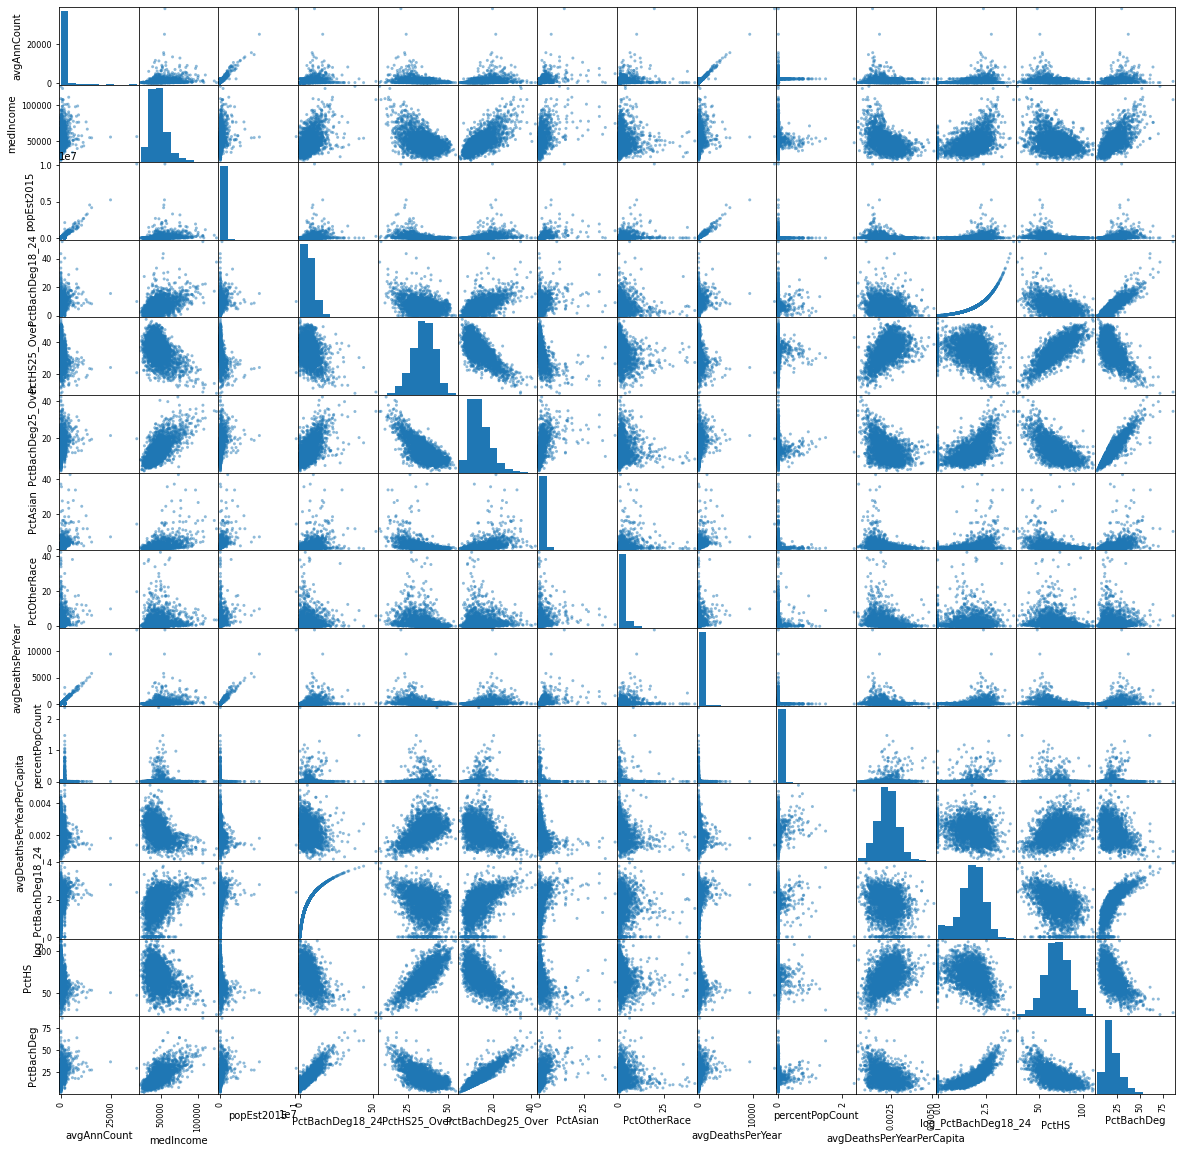

In [73]:
pd.plotting.scatter_matrix(correlated_df, figsize=(20, 20))
plt.show()

In [74]:
correlated_df['Pct_HS_UP'] = correlated_df['PctHS'] + correlated_df['PctBachDeg']
correlated_df.head()

avgAnnCount  medIncome  popEst2015  PctBachDeg18_24  PctHS25_Over  \
0       1397.0      61898      260131              6.9          23.2   
1        173.0      48127       43269              7.5          26.0   
2        102.0      49348       21026              9.5          29.0   
3        427.0      44243       75882              2.5          31.6   
4         57.0      49955       10321              2.0          33.4   

   PctBachDeg25_Over  PctAsian  PctOtherRace  avgDeathsPerYear  \
0               19.6  4.821857      1.843479               469   
1               22.7  2.246233      3.741352                70   
2               16.0  0.465898      2.747358                50   
3                9.3  1.161359      1.362643               202   
4               15.0  0.665830      0.492135                26   

   percentPopCount  avgDeathsPerYearPerCapita  log_PctBachDeg18_24  PctHS  \
0         0.005370                   0.001803             2.066863   62.7   
1         0.003998                   0.001618             2.140066   48.4   
2         0.004851                   0.002378             2.351375   65.6   
3         0.005627                   0.002662             1.252763   72.8   
4         0.005523                   0.002519             1.098612   76.4   

   PctBachDeg  Pct_HS_UP  
0        26.5       89.2  
1        30.2       78.6  
2        25.5       91.1  
3        11.8       84.6  
4        17.0       93.4

In [75]:
correlated_df.corr().abs()

avgAnnCount  medIncome  popEst2015  \
avgAnnCount                   1.000000   0.269145    0.926894   
medIncome                     0.269145   1.000000    0.235523   
popEst2015                    0.926894   0.235523    1.000000   
PctBachDeg18_24               0.284176   0.492810    0.248375   
PctHS25_Over                  0.311375   0.471348    0.311849   
PctBachDeg25_Over             0.321021   0.704928    0.297463   
PctAsian                      0.435071   0.425844    0.464168   
PctOtherRace                  0.209184   0.083635    0.241468   
avgDeathsPerYear              0.939408   0.223207    0.977634   
percentPopCount               0.161177   0.029110    0.051793   
avgDeathsPerYearPerCapita     0.187947   0.481910    0.242346   
log_PctBachDeg18_24           0.264339   0.457553    0.227255   
PctHS                         0.280361   0.367755    0.260593   
PctBachDeg                    0.339808   0.679293    0.307253   
Pct_HS_UP                     0.076925   0.093089    0.078642   

                           PctBachDeg18_24  PctHS25_Over  PctBachDeg25_Over  \
avgAnnCount                       0.284176      0.311375           0.321021   
medIncome                         0.492810      0.471348           0.704928   
popEst2015                        0.248375      0.311849           0.297463   
PctBachDeg18_24                   1.000000      0.384049           0.599814   
PctHS25_Over                      0.384049      1.000000           0.740611   
PctBachDeg25_Over                 0.599814      0.740611           1.000000   
PctAsian                          0.345883      0.436561           0.437963   
PctOtherRace                      0.006547      0.285611           0.039075   
avgDeathsPerYear                  0.259761      0.295929           0.293210   
percentPopCount                   0.079820      0.015770           0.041023   
avgDeathsPerYearPerCapita         0.236672      0.523673           0.459435   
log_PctBachDeg18_24               0.888642      0.309488           0.536207   
PctHS                             0.454870      0.803926           0.648136   
PctBachDeg                        0.874027      0.645515           0.913023   
Pct_HS_UP                         0.143230      0.493740           0.071970   

                           PctAsian  PctOtherRace  avgDeathsPerYear  \
avgAnnCount                0.435071      0.209184          0.939408   
medIncome                  0.425844      0.083635          0.223207   
popEst2015                 0.464168      0.241468          0.977634   
PctBachDeg18_24            0.345883      0.006547          0.259761   
PctHS25_Over               0.436561      0.285611          0.295929   
PctBachDeg25_Over          0.437963      0.039075          0.293210   
PctAsian                   1.000000      0.200781          0.443074   
PctOtherRace               0.200781      1.000000          0.215149   
avgDeathsPerYear           0.443074      0.215149          1.000000   
percentPopCount            0.051698      0.012230          0.058873   
avgDeathsPerYearPerCapita  0.353250      0.307237          0.200451   
log_PctBachDeg18_24        0.281573      0.036559          0.243338   
PctHS                      0.356358      0.186621          0.252153   
PctBachDeg                 0.442278      0.027066          0.310474   
Pct_HS_UP                  0.089174      0.216597          0.065154   

                           percentPopCount  avgDeathsPerYearPerCapita  \
avgAnnCount                       0.161177                   0.187947   
medIncome                         0.029110                   0.481910   
popEst2015                        0.051793                   0.242346   
PctBachDeg18_24                   0.079820                   0.236672   
PctHS25_Over                      0.015770                   0.523673   
PctBachDeg25_Over                 0.041023                   0.459435   
PctAsian                          0.051698                   0.353250   


In [76]:
features_to_use = ['PctAsian', 'PctOtherRace', 'Pct_HS_UP']
target_per_capita

'avgDeathsPerYearPerCapita'

In [77]:
ols = sf.check_model(df=correlated_df, features_to_use=features_to_use, target_col=target_o, show_summary=True, add_constant=False)

                                 OLS Regression Results                                
Dep. Variable:       avgDeathsPerYear   R-squared (uncentered):                   0.307
Model:                            OLS   Adj. R-squared (uncentered):              0.306
Method:                 Least Squares   F-statistic:                              449.7
Date:                Thu, 29 Oct 2020   Prob (F-statistic):                   7.47e-242
Time:                        07:42:29   Log-Likelihood:                         -22919.
No. Observations:                3047   AIC:                                  4.584e+04
Df Residuals:                    3044   BIC:                                  4.586e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

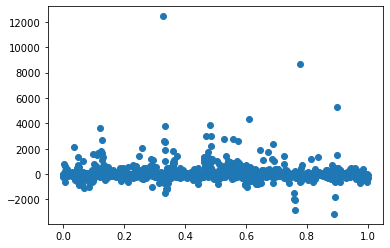

In [82]:
sf.plot_residuals(ols)

# Cross Validate in sklearn

In [83]:
linear = LinearRegression(fit_intercept=False)

In [84]:
X = correlated_df[features_to_use]
y = correlated_df[target_o]

In [85]:
cross_val_score(linear, X, y, n_jobs=-1, cv=5, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.2s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


array([ 0.38338688,  0.2472086 ,  0.10599085,  0.07304149, -0.19096607])

# Train Test Split

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [87]:
linear.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

In [88]:
linear.coef_

array([78.37464261, 20.422889  ,  0.51285935])

In [89]:
linear.score(X_train, y_train), linear.score(X_test, y_test)

(0.21829417501590642, 0.19141684630491673)